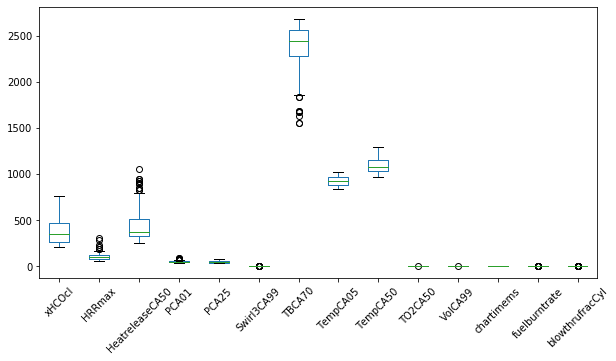

In [7]:
import os
import numpy as np
import torch.nn as nn
import pickle
import random
import pandas as pd
import torch
from torch.autograd import Variable
from pandas_ods_reader import read_ods
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
% matplotlib inline

xHCOcI_thresh = 200
xHCOcI_thresh2 = 900
# Import data start with HCaltitude.ods
num_list = []
path = 'data/HCaltitude.ods'
sheet_idx = 1
df = read_ods(path, sheet_idx)

# Select columns which are common among three data sets
df= df.drop(columns=['Sno', 'HCUDF', 'HCUDFpolynomial'])
columns = list(df.columns)
filter = df['xHCOcI'] > xHCOcI_thresh
df = df.loc[filter]
filter = df['xHCOcI'] < xHCOcI_thresh2
df = df.loc[filter]
data = df[columns]
num_list.append(data.shape[0])

# Import other two kinds of data
paths = ['data/HCDOE.ods']
for path in paths:
    sheet_idx = 1
    df = read_ods(path, sheet_idx)
    df = df[columns]
    filter = df['xHCOcI'] > xHCOcI_thresh
    df = df.loc[filter]
    filter = df['xHCOcI'] < xHCOcI_thresh2

    df = df.loc[filter]
    data = pd.concat([data, df])
    num_list.append(data.shape[0])
data_origin = data.copy()
num_list_origin = num_list.copy()

n1 = num_list[0]
n2 = num_list[1] - num_list[0]

# Visulize filtered data
boxplot = data.boxplot(grid=False, figsize=(10,5), rot=45, return_type='dict')



In [8]:
data = data.to_numpy()

# Scale data to [0,1]
scalerX = preprocessing.MinMaxScaler().fit(data[:, 1:])
scalery = preprocessing.MinMaxScaler().fit(data[:, 0:1])
data[:, 1:] = scalerX.transform(data[:, 1:])
# data[:, 0:1] = scalery.transform(data[:, 0:1])

# HCaltitude as target set
y_target = torch.from_numpy(data[:num_list[0], 0:1]).to(dtype=torch.float32).cuda()
x_target = torch.from_numpy(data[:num_list[0], 1:]).to(dtype=torch.float32).cuda()

# Set the other two sets for training and testing with properation of 7:3
HCDOE = data[num_list[0]:num_list[1], :]
training_size = [int(0.7 * n2)]
test_size = [n2 - int(0.7 * n2)]
batch_list = [[item for item in range(training_size[0])]]
chosen_size = [training_size[0] + test_size[0]]



chosen_list = [item for item in range(HCDOE.shape[0])]
random.shuffle(chosen_list)
x_training = HCDOE[chosen_list[:training_size[0]], 1:]
y_training = HCDOE[chosen_list[:training_size[0]], 0:1]
x_test = HCDOE[chosen_list[training_size[0]:chosen_size[0]], 1:]
y_test = HCDOE[chosen_list[training_size[0]:chosen_size[0]], 0:1]




In [9]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

estimator = SVR(kernel='linear', gamma='auto', C=10000.0)
estimator.fit(x_training, y_training)
y_pred = estimator.predict(x_test)
r2_score(y_test, y_pred)

# batch_content = random.sample(batch_list[dataset_idx], batch_size)
# x_batch = x_training[dataset_idx][batch_content, :]
# y_batch = y_training[dataset_idx][batch_content]
# # Update process
# y_pred = net(x_batch)
# loss = MSELoss(y_pred, y_batch)
# optimizer.zero_grad()
# loss.backward(retain_graph=True)
# optimizer.step()

# # Test    
# y_pred = net(x_test_0)
# y_real = y_test_0
# #     y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# #     y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
# loss_0 = MSELoss(y_pred, y_real)
# loss_0 = torch.sqrt(loss_0.data)
# #     loss_0 = MSELoss(y_pred, y_real) / (torch.mean(y_real) ** 2)

# print('epoch: %d || DOE: %f' % (step, loss_0.data))
# loss = loss_0
# if step > 10:
#     if weight_flag == 0:
#         # Save weights
#         weight_name = 'out/model_%d.ckpt' % (step)
#         torch.save(net.state_dict(), weight_name)
#         weight_flag = 1
#         best_one = loss.data
#     else:
#         if loss.data < best_one:
#             weight_name = 'out/model_%d_%.1f.ckpt' % (step, loss.data)
#             torch.save(net.state_dict(), weight_name)
#             best_one = loss.data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.03433968327695747

In [27]:
r_list = []
net.load_state_dict(torch.load('out/model_17813_127.3.ckpt'))
y_pred = net(x_test_0)
y_real = y_test_0
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_0 = MSELoss(y_pred, y_real)


t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())
plt.legend(['prediction', 'observation'])
plt.xlabel('DOE sample points')
plt.ylabel('HCOcl value')
plt.title('RMSE = %0.2f' % torch.sqrt(loss_0.data))
plt.savefig('DOE.png', dpi=400)
plt.close()

y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('R-squared = %0.2f' % r)
plt.savefig('DOE_r.png', dpi=400)
plt.close()


print('epoch: %d || DOE: %f' % (step, torch.sqrt(loss_0.data)))
print(r_list)

epoch: 26417 || DOE: 127.266273
[-0.07701432704925537]


In [4]:
a = [[1, 2], [2, 3], [1,3]]

In [5]:
a.sort()

In [6]:
a

[[1, 2], [1, 3], [2, 3]]